## Check GPU compatibility

In [1]:
import tensorflow as tf

In [2]:
# Avoid OOM (out of memory) errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import Libraries

In [4]:
import os, random
import numpy as np
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE

## Build the pipeline

Details about the dataset:

In [5]:
base_path = 'combined_dataset'

In [6]:
total_images = 0
class_counts = {}
classes = os.listdir(base_path)

for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        num_images = len(images)
        total_images += num_images
        class_counts[class_name] = num_images

print("Total number of images in the dataset:", total_images)
print("Number of images in each class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Total number of images in the dataset: 7163
Number of images in each class:
metal: 1731
paper: 3267
plastic: 2165


## Create the image dataset

In [7]:
img_height = 180
img_width = 180
batch_size = 32

In [8]:
data = tf.keras.utils.image_dataset_from_directory(
    base_path,
    labels='inferred',  # labels are generated from the directory structure.
    label_mode='categorical',  # "label_mode": String describing the encoding of `labels`.
    # 'categorical':means that the labels are encoded as a categorical vector (e.g. for `categorical_crossentropy` loss).
    seed=1,
    image_size=(img_height, img_width),
    shuffle=True,  # that means that it will shuffle the dataset on every Epoch!
    crop_to_aspect_ratio=True,
    batch_size=batch_size
)

Found 7163 files belonging to 3 classes.


In [9]:
class_names = data.class_names
class_names

['metal', 'paper', 'plastic']

## Show samples

In [10]:
def show_samples(data, dim):

    # can be imporved regarding dimension of the plot
    
    #class_names = data.class_names
    element = next(iter(data))  # or: element = data.as_numpy_iterator().next()
    # element: a single output from calling `next()` on a dataset iterator.
    # Elements may be nested structures containing multiple components.  # component: the leaf in the nested structure of an element.

    fig, ax = plt.subplots(ncols=dim, figsize=(20,20))
    
    for idx in range(dim):
        sample_image = element[0][idx]/255
        ax[idx].imshow(sample_image)
        ax[idx].set_title(class_names[np.argmax(element[1][idx])])
    plt.tight_layout()
    plt.show()

## Scale Data

In [11]:
preprocess_fn = tf.keras.applications.densenet.preprocess_input

### to check what is the min and max valeus of data

## Split data

Dataset should have been shuffled before this step!

In [12]:
# total number of batches
data_size = len(data)
data_size

224

In [13]:
train_size = int(data_size * 0.72) + 1  # used to train our model
val_size = int(data_size * 0.08) + 1  # used to evaluate our model while training
test_size = int(data_size * 0.20)  # used for the final evaluation after the model has finished training

In [14]:
print(f"train_size = {train_size}\nval_size = {val_size}\ntest_size = {test_size}\ntotal_size = {train_size+val_size+test_size}")
if data_size != train_size+val_size+test_size: assert False, "Fix the (+1) thing above!"

train_size = 162
val_size = 18
test_size = 44
total_size = 224


In [15]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [16]:
print(f"Number of batches of:\ntrain = {len(train)}\nval = {len(val)}\ntest = {len(test)}\ntotal = {len(train)+len(val)+len(test)}")

Number of batches of:
train = 162
val = 18
test = 44
total = 224


### Cache before augmentation

In [ ]:
train = train.cache()
val = val.cache()
test = test.cache()

### Check how many images in a dataset

In [17]:
def image_count():
    
    datasets = {'train': train, 'val': val, 'test': test}
    total_img = 0
    total_i = 0
    
    for dataset_name, dataset in datasets.items():
        
        num_img = 0 
        i = 0
    
        for batch in dataset:
            i += 1
            num_img += batch[0].shape[0]

        total_img += num_img
        total_i += i
        print(f"Number of batches in '{dataset_name}' dataset: {i}")
        print(f"Total number of images in all batches in '{dataset_name}' dataset: {num_img}")
        print("**********************************************************************")

    print("Total number of batches in all datasets: ", total_i)
    print("Total number of images in all datasets: ", total_img)

### Show some samples

## First Data Augmentation

In [ ]:
from tensorflow.image import stateless_random_flip_left_right, stateless_random_brightness, stateless_random_contrast  # https://www.tensorflow.org/api_docs/python/tf/image

In [ ]:
# https://www.youtube.com/watch?v=CLHk6DniYg0
def augment(image, label):
    image = stateless_random_flip_left_right(image, (2,0))
    image = stateless_random_brightness(image, 1, (2,0))
    #image = stateless_random_contrast(image, 0.05 ,0.15, (2,0))
    return (image, label)

In [ ]:
train = train.map(augment, num_parallel_calls=AUTOTUNE)

In [ ]:
# show a test of augmented images
tuple = train.as_numpy_iterator().next()

plt.imshow(tuple[0][2]/255)
plt.title(class_names[np.argmax(tuple[1][2])])
plt.show()

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide. https://www.tensorflow.org/guide/data_performance

num_parallel_calls: (Optional.) A `tf.int64` scalar `tf.Tensor`,
        representing the number of batches to compute asynchronously in
        parallel.\
        If not specified, batches will be computed sequentially. If the value
        `tf.data.AUTOTUNE` is used, then the number of parallel
        calls is set dynamically based on available resources.

In [18]:
train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

## Deep model

In [19]:
from keras import Model
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.layers import RandomRotation, RandomTranslation, RandomZoom, RandomFlip  # https://keras.io/api/layers/preprocessing_layers/image_augmentation/

### Data Augemntation

In [20]:
data_augmentation = Sequential([
    RandomRotation(0.3),  # 30-degree rotation
    RandomTranslation(0.2, 0.2),  # 0.2 percent shift horizontally and vertically
    RandomZoom(0.2),  # 0.2 zoom range
    RandomFlip('horizontal'),  # y-axis flip (horizontal flip)
])

- Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using Dataset.prefetch, shown below.
- In this case the preprocessing layers will not be exported with the model when you call Model.save. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.
- https://www.tensorflow.org/tutorials/images/data_augmentation
- https://www.tensorflow.org/tutorials/images/classification

### Create the base model from the pre-trained convnets

In [21]:
pretrained_model = tf.keras.applications.densenet.DenseNet169(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
    #pooling='avg'  # Global Average Pooling
    # To generate predictions from the block of features, average over the spatial 5x5 spatial location,
    # to convert the features to a single 1664-element vector per image.
)

# https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet169

In [22]:
# Assuming `model` is your pre-trained model instance
num_fc_layers = sum(isinstance(layer, Dense) for layer in pretrained_model.layers)
print("Number of fully connected layers:", num_fc_layers)

Number of fully connected layers: 0


### Feature extraction

Freeze the convolutional base

In [23]:
# Assuming `model` is your pre-trained model
trainable_layers = sum(1 for layer in pretrained_model.layers if layer.trainable)
print("Number of trainable layers:", trainable_layers)

Number of trainable layers: 595


In [24]:
pretrained_model.trainable = False  # to freeze all layers

In [25]:
# Assuming `model` is your pre-trained model
trainable_layers = sum(1 for layer in pretrained_model.layers if layer.trainable)
print("Number of trainable layers:", trainable_layers)

Number of trainable layers: 0


**Important note about BatchNormalization layers**
Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.rned.

In [ ]:
pretrained_model.summary(show_trainable=True)

In [26]:
preprocess_input = tf.keras.applications.densenet.preprocess_input
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(3, activation='softmax')

In [27]:
inputs = Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = pretrained_model(x, training=False)
x = global_average_layer(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)

model = Model(inputs, outputs)

In [28]:
model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         Y          
                                                                            
 sequential (Sequential)     (None, 180, 180, 3)       0         Y          
                                                                            
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         Y          
 )                                                                          
                                                                            
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         Y          
                                                                            
 tf.math.truediv_1 (TFOpLamb  (None, 180, 180, 3)      0         Y          
 da)                                                         

The 12+ million parameters in DenseNet are frozen, but there are 1.6 thousand trainable parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

In [68]:
base_learning_rate = 0.0001  # default = 0.001

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

### Sense Check Predictions (check densenet model before anything)

In [29]:
yx = model.predict(val)
yx

18/18 [==============================] - 18s 63ms/step


array([[0.18895437, 0.45911396, 0.35193166],
       [0.16995077, 0.6538388 , 0.17621045],
       [0.2566307 , 0.4746478 , 0.26872155],
       ...,
       [0.30829266, 0.408176  , 0.2835313 ],
       [0.09295075, 0.5910441 , 0.31600514],
       [0.25111866, 0.54216737, 0.2067139 ]], dtype=float32)

In [37]:
# Finding the minimum and maximum values
min_value = np.min(yx)
max_value = np.max(yx)

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 0.008963411
Maximum value: 0.9078627


In [31]:
yx.shape

(576, 3)

In [43]:
# Plot the images along with their predicted and actual labels
tuple = val.as_numpy_iterator().next()

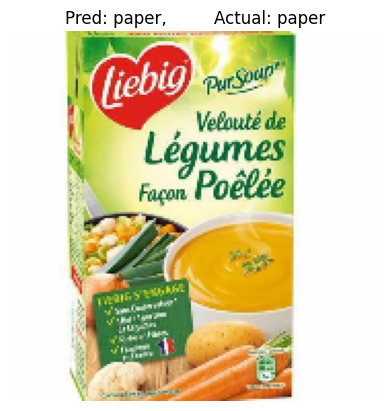

In [65]:
idx = 21
plt.imshow(tuple[0][idx]/255)
plt.title(f'Pred: {class_names[np.argmax(yx[idx])]},         Actual: {class_names[np.argmax(tuple[1][idx])]}')
plt.axis('off')
plt.show()

## Train the model

In [66]:
initial_epochs = 20

### get a sense of the model

In [69]:
loss0, accuracy0 = model.evaluate(val, verbose=0)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.27
initial accuracy: 0.35


In [70]:
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard

logdir = 'logs\logs_v83'
tensorboard_callback = TensorBoard(log_dir=logdir)

file_cp = "saved_models\saved_models_v83/trashTESTv83_{epoch:02d}_{val_accuracy:.2f}.model.keras"
checkpoint = ModelCheckpoint(file_cp, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_csv = CSVLogger('first_trashTESTv83.csv', separator=',', append=True)

callbacks_list = [checkpoint, log_csv, tensorboard_callback]

In [71]:
history = model.fit(train,
                    epochs=initial_epochs,
                    validation_data=val,
                    callbacks=callbacks_list
                   )

Epoch 1/20
162/162 [==============================] - ETA: 0s - loss: 0.7179 - accuracy: 0.6935
Epoch 1: val_accuracy improved from -inf to 0.90278, saving model to saved_models\saved_models_v83\trashTESTv83_01_0.90.model.keras
162/162 [==============================] - 88s 479ms/step - loss: 0.7179 - accuracy: 0.6935 - val_loss: 0.3039 - val_accuracy: 0.9028
Epoch 2/20
162/162 [==============================] - ETA: 0s - loss: 0.4149 - accuracy: 0.8457
Epoch 2: val_accuracy did not improve from 0.90278
162/162 [==============================] - 77s 473ms/step - loss: 0.4149 - accuracy: 0.8457 - val_loss: 0.2910 - val_accuracy: 0.8976
Epoch 3/20
162/162 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.8692
Epoch 3: val_accuracy improved from 0.90278 to 0.92708, saving model to saved_models\saved_models_v83\trashTESTv83_03_0.93.model.keras
162/162 [==============================] - 80s 490ms/step - loss: 0.3461 - accuracy: 0.8692 - val_loss: 0.1990 - val_accuracy:

In [72]:
model.save("full_saved_model\TF_FT_trashTESTv83.h5")

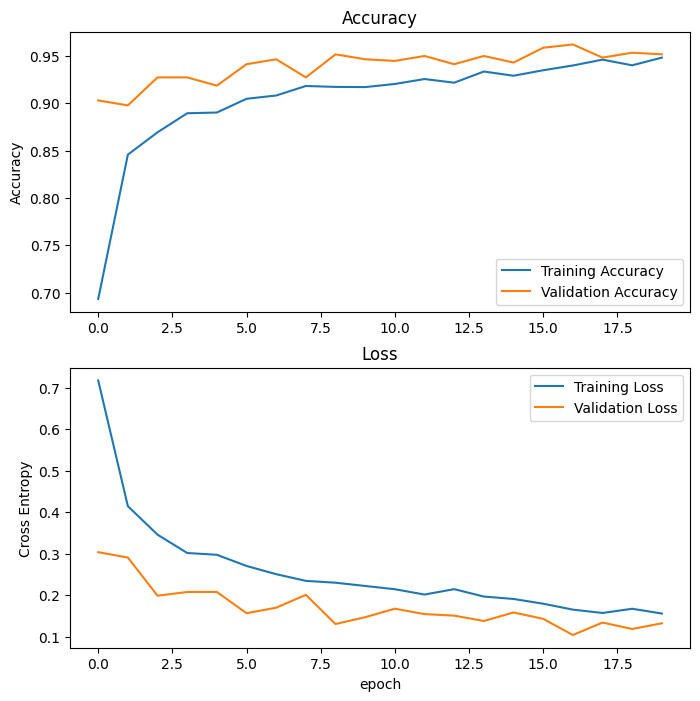

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

**Note:** If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.\
To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

### Fine tuning

Un-freeze the top layers of the model

In [ ]:
len(pretrained_model.layers)

In [ ]:
pretrained_model.trainable = True

In [ ]:
# Assuming `model` is your pre-trained model
trainable_layers = sum(1 for layer in pretrained_model.layers if layer.trainable)
print("Number of trainable layers:", trainable_layers)

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 550  ## starting from "fine_tune_at" onward will be trainable.

In [ ]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# Assuming `model` is your pre-trained model
trainable_layers = sum(1 for layer in pretrained_model.layers if layer.trainable)
print("Number of trainable layers:", trainable_layers)

In [ ]:
base_learning_rate = 0.00001  # default = 0.001

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [ ]:
model.summary(show_trainable=True)

In [ ]:
len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs  # 20 + 10

In [ ]:
history_fine = model.fit(train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val)

In [ ]:
model.save("full_saved_model\TF_FT_trashTESTv82FT.h5")

## Plotting

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### model.fit(): if x {train} is an object of tf.data.Dataset (as in our case):
- "y" shouldn't be specified,
- "shuffle" is ignored,
- don't specify "batch_size",
- "validation_split" is not supported,
- "sample_weight" is not supported,
- don't specify "validation_batch_size".

### from https://www.tensorflow.org/tutorials/images/transfer_learning

**Evaluation and prediction:** Finally you can verify the performance of the model on new data using test set.


In [ ]:
loss, accuracy = model.evaluate(train)
print('Test accuracy :', accuracy)

In [ ]:
# the following is very useful to predict a batch of the dataset

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Predction

In [74]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, SparseCategoricalAccuracy

In [75]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [76]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X, verbose=0)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [77]:
print(f"Percsion: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Percsion: 0.9569584131240845, Recall: 0.9508196711540222, Accuracy: 0.9529579281806946


# Test

In [78]:
import cv2

In [ ]:
#img = cv2.imread('trash_but_not_TrashNet\plastic\plastic563.jpg')

class_to_test = 'cardboard'

img_to_test = class_to_test + '20'

path_to_test = os.path.join('TrashNet', class_to_test, img_to_test + '.jpg')

patth = 'IMG_2411.jpg'

img = cv2.imread(patth)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
resize = tf.image.resize(img, (160, 160))
plt.imshow(cv2.cvtColor(resize.numpy()/255, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize, 0))
classes[np.argmax(yhat)]

In [90]:
# Function to preprocess image
def preprocess_image(image_path, target_size=(img_height, img_width)):
    img = cv2.imread(image_path)
    resized_img = tf.image.resize(img, target_size)
    return np.expand_dims(resized_img, 0)

In [91]:
def predict_and_plot(image_path, model, classes):
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    predicted_class = classes[np.argmax(prediction)]
    
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(predicted_class)
    plt.axis('off')
    plt.show()

In [ ]:
# Path to the folder containing images
folder_path = 'trash_from_jordan'

# Get all files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('jpg', 'jpeg', 'png', 'gif'))]

# Paths to images
for image_path in image_files:
    predict_and_plot(image_path, model, classes)

# Save/Load the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
loaded_model_1 = load_model('saved_models_v5\\trashTESTv5_38_0.81.model.keras')

In [ ]:
loaded_model_1.predict(np.expand_dims(resize/255, 0))

# trashTESTv3

In [ ]:
# Evaluate model performance on training, validation, and testing dataset:
train_score = model.evaluate(train, verbose= 1)
valid_score = model.evaluate(val, verbose= 1)
test_score = model.evaluate(test, verbose= 1)

In [ ]:
print(f"Train results: Acc ={train_score[1]*100: .2f}%, Loss ={train_score[0]: .5f}")

In [ ]:
print(f"Validation results: Acc ={valid_score[1]*100: .2f}%, Loss ={valid_score[0]: .5f}")

In [ ]:
print(f"Test results: Acc ={test_score[1]*100: .2f}%, Loss ={test_score[0]: .5f}")

### Classification Report

In [79]:
# Initialize an empty list to store true labels and predictions
true_labels = []
predictions = []

# Iterate over batches in the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X, verbose=0)
    true_labels.extend(np.argmax(y, axis=1))  # Append true labels to the list
    predictions.extend(np.argmax(yhat, axis=1))  # Append predictions to the list

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

Accuracy: 95.15%
F1-score: 95.16%
Precision: 95.17%
Recall: 95.15%


In [ ]:
class_names

In [81]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classification report
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

       metal       0.94      0.97      0.95       337
       paper       0.97      0.96      0.96       634
     plastic       0.94      0.93      0.94       432

    accuracy                           0.95      1403
   macro avg       0.95      0.95      0.95      1403
weighted avg       0.95      0.95      0.95      1403



In [82]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

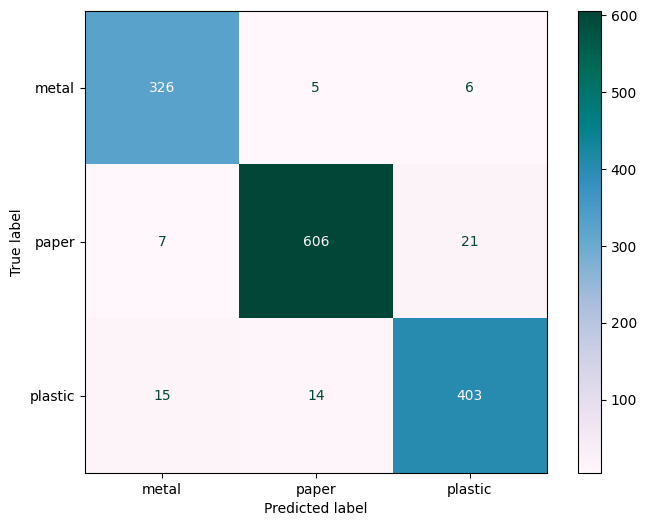

In [83]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.PuBuGn)
plt.show()

In [84]:
test_no_trashnet = tf.keras.utils.image_dataset_from_directory(
    'trash_but_not_TrashNet_3',
    labels='inferred',
    label_mode='categorical',
    #seed=1,
    image_size=(img_height, img_width),
    shuffle=False
    #batch_size=batch_size,
)

Found 1690 files belonging to 3 classes.


# Evaluation on trash but not TrashNet

In [85]:
# Initialize an empty list to store true labels and predictions
true_labels = []
predictions = []

# Iterate over batches in the test dataset
for batch in test_no_trashnet.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X, verbose=0)
    true_labels.extend(np.argmax(y, axis=1))  # Append true labels to the list
    predictions.extend(np.argmax(yhat, axis=1))  # Append predictions to the list

In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

Accuracy: 90.53%
F1-score: 90.36%
Precision: 90.45%
Recall: 90.53%


In [87]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classification report
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

       metal       0.91      0.81      0.85       359
       paper       0.92      0.98      0.95       944
     plastic       0.87      0.82      0.85       387

    accuracy                           0.91      1690
   macro avg       0.90      0.87      0.88      1690
weighted avg       0.90      0.91      0.90      1690



In [88]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

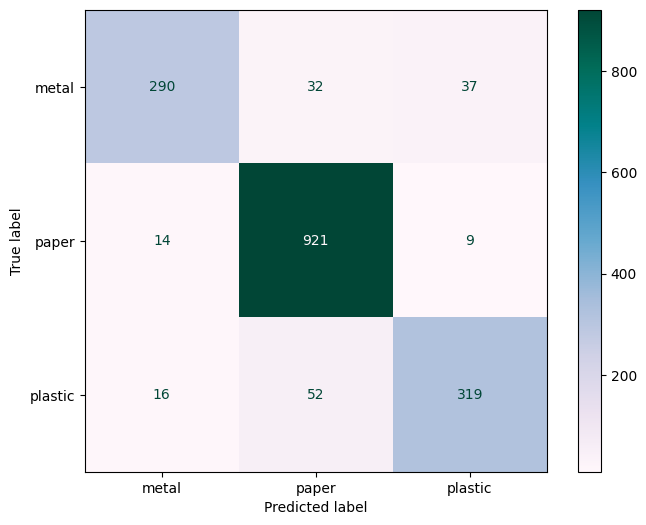

In [89]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.PuBuGn)
plt.show()

# Loading


In [ ]:
import cv2

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('full_saved_model\TF_FT_trashTESTv82.h5')

In [ ]:
# Path to the folder containing images
folder_path = 'trash_from_jordan'

# Get all files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('jpg', 'jpeg', 'png', 'gif'))]

# Paths to images
for image_path in image_files:
    predict_and_plot(image_path, model, classes)

1/1 [==============================] - 0s 34ms/step


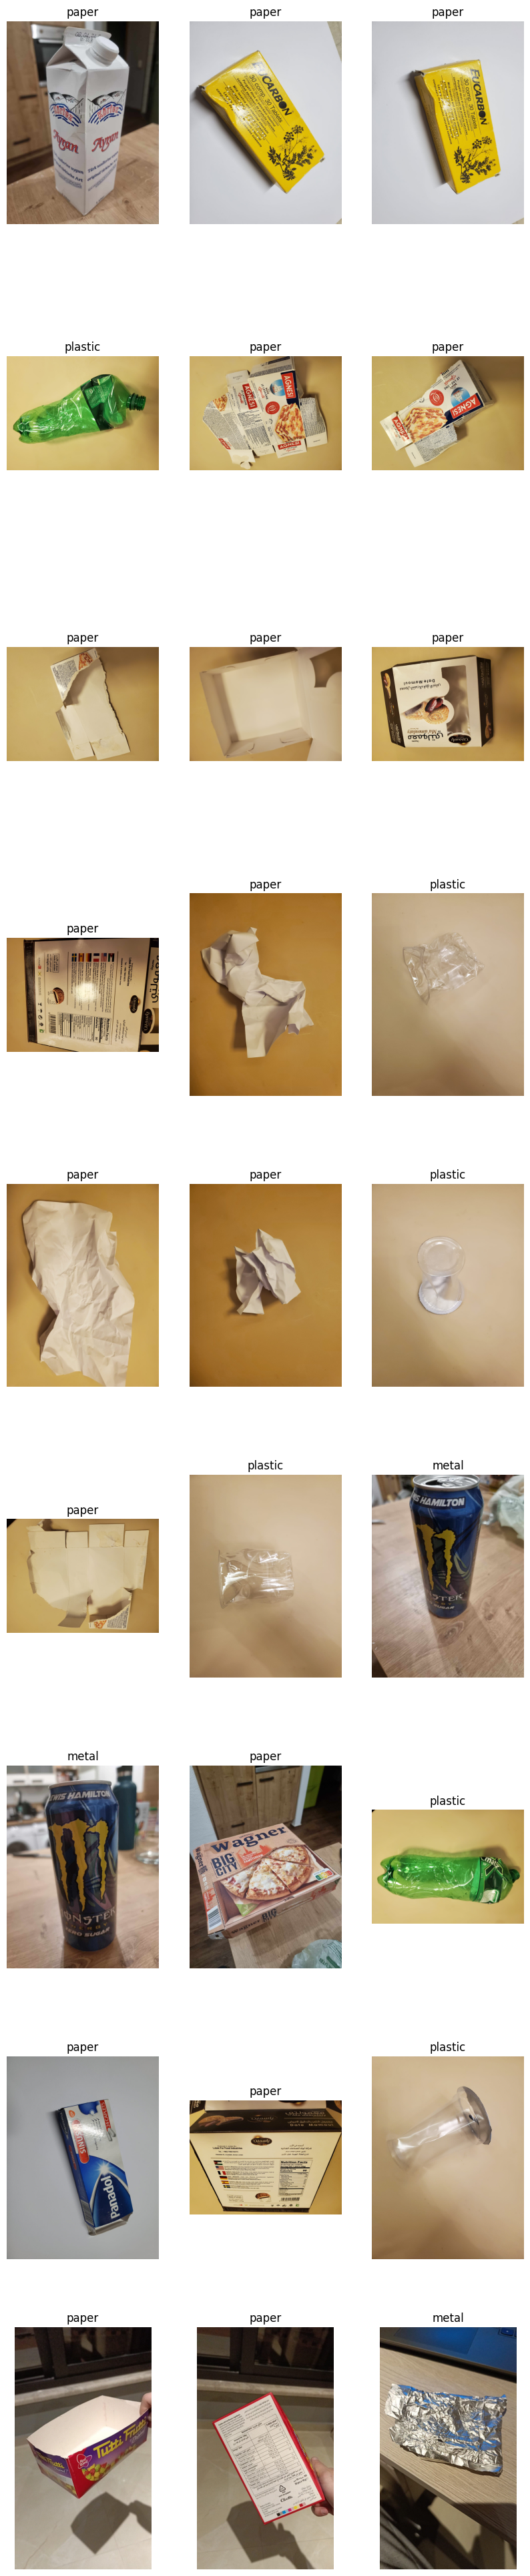

In [99]:
# Path to the folder containing images
folder_path = 'All_datasets\my_dataset'

# Get all files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('jpg', 'jpeg', 'png', 'gif'))]

# Paths to images

i = 0
plt.figure(figsize=(10, 50))
for image_path in image_files:
    ax = plt.subplot(9, 3, i + 1)
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(classes[np.argmax(prediction)])
    plt.axis("off")
    i+=1

In [ ]:
import cv2

1/1 [==============================] - 0s 34ms/step


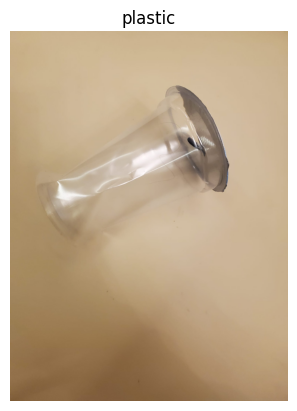

In [98]:
path = 'All_datasets\my_dataset\IMG_3006.jpg'
predict_and_plot(path, model, classes)

In [ ]:
# Initialize an empty list to store true labels and predictions
true_labels = []
predictions = []

# Iterate over batches in the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = loaded_model.predict(X)
    true_labels.extend(np.argmax(y, axis=1))  # Append true labels to the list
    predictions.extend(np.argmax(yhat, axis=1))  # Append predictions to the list

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

In [ ]:
target_n = ["Cardboard", "Glass", "Metal", "Paper", "Plastic", "Trash"]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classification report
print(classification_report(true_labels, predictions, target_names=target_n))

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=target_n)

In [ ]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.PuBuGn)
plt.show()